### Langgraph

LangGraph(랭그래프)는 LangChain 생태계 위에 구축된 상태 기반(stateful) 에이전트 오케스트레이션 프레임워크로, 복잡하고 유연한 AI 에이전트 워크플로우를 그래프 구조로 정의하고 제어할 수 있게 도와줍니다.

In [2]:
!pip install langgraph langchain_ollama dotenv langchain_community -q

In [3]:
from dotenv import load_dotenv
from langchain_ollama import ChatOllama

load_dotenv(override=True)

model_name = 'qwen3:4b'
llm = ChatOllama(model = model_name, temperature=0.7, max_tokens=4096, reasoning=True)

llm.invoke("안녕? 너는 Gemini야?")

AIMessage(content='안녕하세요! 그런데 저는 Gemini가 아닙니다. 저는 알리바바 그룹 산하 Tongyi 실험실에서 개발한 초대규모 언어 모델인 Qwen입니다. 궁금한 점이 있으면 도와드리겠습니다!', additional_kwargs={'reasoning_content': 'Okay, the user is asking if I\'m Gemini. Let me think.\n\nFirst, I need to clarify what they mean by Gemini. In the context of AI models, Gemini is a series of models developed by Google, right? So the user might be confusing me with the Gemini series.\n\nI am Qwen, the large language model developed by Tongyi Lab. I should correct them politely.\n\nI should respond in Korean since the user\'s question is in Korean. Let me check the translation.\n\nThe user said "안녕? 너는 Gemini야?" which translates to "Hello? Are you Gemini?"\n\nSo my response should be in Korean. Let me structure it.\n\nFirst, acknowledge their greeting. Then state that I\'m not Gemini but Qwen. Maybe add a bit about what I can do.\n\nWait, the user might be a non-native speaker, so I should keep it simple.\n\nLet me draft: "안녕하세요! 그런데 저는 Gemini가 아닙니다. 저는 알리바바

### Graph 구성 요소: 노드, 엣지, 그래프

랭체인에서는 주로 **Prompt|LLM|Parser** 구조를 하나의 체인으로 구성했는데요.   

랭그래프에서는 보다 복잡한 Workflow를 구성할 수 있습니다.

- 먼저, 가장 작은 작업의 단위를 노드(점)으로 구성합니다.
- 하나의 동작(노드)을 수행하고, 다음 동작(노드)로 이동하는 과정을 엣지(선)으로 표현합니다.
- 시작점인 START 노드에서, 끝점인 END까지 도달하는 과정을 그래프로 구현합니다.   
- 전체 그래프는 `invoke()`를 통해 실행합니다.

가장 기본적인 구조인 **Prompt Chaining**을 통해, 랭그래프의 기본 구조에 대해 알아보겠습니다.

### State

랭그래프의 핵심은 **State** 기반의 Workflow 구성입니다.  

랭그래프는 전체 작업에 관여하는 변수들을 사전에 정의하고, 이를 State로 구성합니다.

State는 초기값에서 시작해 노드와 엣지를 통과하며 그 값이 수정되거나 추가되는 과정을 거치게 됩니다.  

In [4]:
from typing_extensions import TypedDict

class State(TypedDict):
    article: str # 입력값 : 자세한 기술 문서
    summary: str # 중간 처리: 문서 요약
    newsletter : str # 최종값: 블로그 뉴스레터 패턴

### Node

노드는 함수로 정의되는데, 주로 하나의 모듈을 하나의 노드로 구성합니다.   
State는 노드를 지나며 새로운 정보를 추가하거나, 값을 수정할 수 있습니다.

In [5]:
from langchain.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser


# 첫 번째 노드: 기술 문서 요약
def summarize_article(state: State) -> State:
    """기술 문서를 핵심 내용 중심으로 요약하는 노드"""

    # 요약을 위한 프롬프트 템플릿
    summary_prompt = ChatPromptTemplate([
        ("human", """
다음 기술 문서를 읽고 핵심 내용을 요약해주세요.

요약 기준:
- 주요 기능과 특징
- 핵심 기술적 개념
- 사용자에게 미치는 영향
- 중요한 수치나 데이터

기술 문서:
{article}

요약:
        """)
    ])

    summary_chain = summary_prompt | llm | StrOutputParser()
    summary = summary_chain.invoke({"article": state["article"]})

    return {"summary": summary}
    # {article} --> {article, summary} 

# 두 번째 노드: 뉴스레터 변환
def create_newsletter(state: State) -> State:
    """요약된 내용을 뉴스레터 형태로 변환하는 노드"""

    # 뉴스레터 생성을 위한 프롬프트 템플릿
    newsletter_prompt = ChatPromptTemplate.from_messages([
        ("human", """
다음 요약된 기술 내용을 바탕으로 독자들이 읽기 쉬운 뉴스레터 형태로 작성해주세요.

뉴스레터 스타일:
- 친근하고 대화체 톤
- 핵심 포인트를 강조
- 독자의 관심을 끄는 제목
- 실용적인 관점에서 설명
- 적절한 이모지 사용

요약 내용:
{summary}

뉴스레터:
        """)
    ])

    # 체인 생성
    newsletter_chain = newsletter_prompt | llm | StrOutputParser()

    # 뉴스레터 생성 실행
    newsletter = newsletter_chain.invoke({"summary": state["summary"]})

    # State 업데이트
    return {"newsletter": newsletter}
    # {'article', 'summary'} --> {'article', 'summary', 'newsletter'}

### Edge와 Graph   

위에서 설정한 State를 이용하여 Graph를 정의합니다.

그래프에 노드와 엣지를 추가합니다.    
START와 END를 import하고, 시작점과 끝점을 정의합니다.

In [6]:
from langgraph.graph import StateGraph, START, END

builder = StateGraph(State)

builder.add_node(summarize_article)
# 이름을 별도로 넣으려면
# builder.add_node('summarize', summarize_article)

builder.add_node(create_newsletter)

builder.add_edge(START, "summarize_article")
builder.add_edge("summarize_article", "create_newsletter")

builder.add_edge("create_newsletter", END)

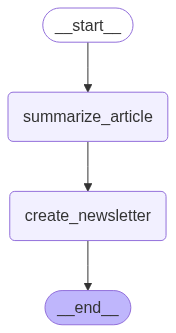

In [7]:
graph = builder.compile()
graph

In [8]:

article='''In this work, we present Qwen3, the latest version of the Qwen model family.'''

response = graph.invoke({'article':article})
response

{'article': 'In this work, we present Qwen3, the latest version of the Qwen model family.',
 'summary': '요약:  \n- **주요 기능과 특징**: Qwen3은 Qwen 모델 가족의 최신 버전으로, 기술 문서에서 구체적인 기능 및 특징에 대한 설명은 없음.  \n- **핵심 기술적 개념**: 기술 문서에서 명시된 핵심 기술적 개념은 없음.  \n- **사용자에게 미치는 영향**: 기술 문서에서 사용자에게 미치는 영향에 대한 정보는 제공되지 않음.  \n- **중요한 수치나 데이터**: 기술 문서에서 제시된 중요한 수치나 데이터는 없음.',
 'newsletter': '**Qwen3 출시 했는데... 기술 문서에 내용이 하나도 없네! 😅**  \n\n안녕하세요, Qwen 가족의 팬 여러분! 🌟  \n\n오늘은 Qwen3에 대한 소식을 알려드릴게요. 🚀  \n\nQwen 모델 가족의 최신 버전인 Qwen3가 출시되었다는 소식을 들었는데요, 기술 문서를 확인해보니...  \n**구체적인 기능, 특징, 사용자 영향, 데이터 등 전혀 언급되지 않았습니다!** 🤯  \n\n이런 상황이면 Qwen3에 대한 기대가 떨어질 수 있지만, 오히려 기술 팀이 아직 준비 중이거나 다른 이유로 정보가 아직 공개되지 않았을 수도 있죠. 😅  \n다음 기술 문서 업데이트가 있을 때 다시 알려드릴게요!  \n혹시 궁금한 점이 있으신 분은 **아래 댓글로** 알려주세요. 🙏  \n\nP.S. Qwen3에 대한 더 궁금한 점이 있다면, 이메일로도 도와드릴게요! (qwen-support@example.com)  \n\n이번 주말까지 기대해 주세요! 🌈'}

### 조건부 엣지와 Message 목록으로 멀티턴 대화 수행

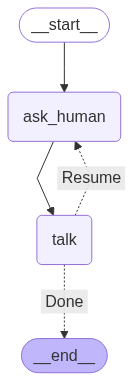

In [9]:
from typing import TypedDict, Annotated
from langgraph.graph.message import add_messages
from langchain_core.messages import HumanMessage, SystemMessage, AIMessage


class State(TypedDict):
    context : Annotated[list, add_messages]
    # 메시지 맥락을 저장하는 리스트:
    # Message를 Return하면 Context에 추가

    count : int # 사용자가 입력한 횟수를 저장

def ask_human(state: State):
    query = input()
    print('User :', query)

    return {'context':HumanMessage(content=query)}
    # State의 add_messages Reducer 규칙에 의해 업데이트가 아닌 추가

def talk(state: State):
    messages = state['context']

    answer = llm.invoke(messages)

    print('AI :', answer.content)
    state['count'] +=1

    return {'context': answer, 'count': state['count']}

def check_end(state: State):
    if state['count']>=3:
        return "Done"
    else:
        return "Resume"
    # count가 3 이상이 되면 True, 이외 False

from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END
from langgraph.graph import MessagesState
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition


builder = StateGraph(State)

builder.add_node(talk)
builder.add_node(ask_human)

builder.add_edge(START, 'ask_human'),
builder.add_edge('ask_human', 'talk'),


# (시작점, 조건, {분기 매핑})
builder.add_conditional_edges('talk', check_end,
                              {'Done': END, 'Resume': 'ask_human'})

graph = builder.compile()
graph

프롬프트를 잘 작성해도 위 행위를 동일하게 할 순 있지만, LLM 에게 물어볼 내용과 구현해야 할 내용을 분리해서 최대한 할루시네이션이 안나타나도록 한다.

In [ ]:
system_prompt = '''사용자의 질문에 대해 친절하게 응답하세요. '''

messages = [SystemMessage(content=system_prompt)]

response = graph.invoke({'context':messages, 'count':0})

response

### [실습] 종료 조건 수정하기

In [ ]:
### 여기서 시작 ###
def ask_human(state: State):
    query = input()
    print('User :', query)

    return {'context':HumanMessage(content=query)}

def talk(state: State):
    messages = state['context']

    answer = llm.invoke(messages)

    print('AI :', answer.content)
    state['count'] +=1

    return {'context': answer, 'count': state['count']}

def check_end(state: State):
    # 마지막 메시지가 'FINISHED'면 종료 
    if state['context'][-1].content=='FINISHED':
        
        print("# Total Conversations : ", state['count'])
        
        return "Done"
    else:
        return "Resume"


builder = StateGraph(State)

builder.add_node(talk)
builder.add_node(ask_human)

builder.add_edge(START, 'ask_human')
# builder.add_edge('ask_human', 'talk')

# (시작점, 조건, {분기 매핑})
builder.add_conditional_edges('ask_human', check_end,
                              {'Done': END, 'Resume': 'talk'})

builder.add_edge('talk', 'ask_human')


graph = builder.compile()
graph

In [ ]:
system_prompt = '''5문장 이내로 답변해줘.'''

messages = [SystemMessage(content=system_prompt)]

response = graph.invoke({'context':messages, 'count':0})

response